In [1]:
import numpy as np
import pandas as pd

In [2]:
data_directory = '/home/mytrah-pc/Data/Mokal_extract/MK014[20170428-060000][20170612-093000].csv'
file_name = ''
file_path = data_directory + file_name

data_set = pd.read_csv(file_path)[['Timestamp', 'WindSpeed', 'ActivePower', 'TurbineState']]
data_set = data_set[data_set['ActivePower'] > 0]
data_set = data_set[data_set['TurbineState'] == 11]
min_WindSpeed = data_set['WindSpeed'].min()
min_ActivePower = data_set['ActivePower'].min()
normalize_WindSpeed_factor = data_set['WindSpeed'].max() - min_WindSpeed
normalize_ActivePower_factor = data_set['ActivePower'].max() - min_ActivePower
data_set['scaled_WindSpeed'] = ((data_set['WindSpeed'] - min_WindSpeed) * 100 / normalize_WindSpeed_factor)
data_set['scaled_ActivePower'] = ((data_set['ActivePower'] - min_ActivePower) * 100 / normalize_ActivePower_factor)

def rounding_method(multiply_factor, round_off_by_factor):
    return lambda number: int(number * multiply_factor) + round_off_by_factor - int(number * multiply_factor) % round_off_by_factor

data_set['discrete_ActivePower'] = data_set['scaled_ActivePower'].apply(rounding_method(1, 2))
data_set.index = pd.to_datetime(data_set['Timestamp'])
del data_set['Timestamp']

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.scatter(data_set['scaled_WindSpeed'], data_set['discrete_ActivePower'])

In [4]:
from sklearn.cluster import KMeans
n_kmeans_clusters = 10
kmeans_alg_obj = KMeans(n_clusters=n_kmeans_clusters)
previous_width = -1
threshold_width_deviation = 1.8
allowed_width_deviation = threshold_width_deviation
epsilon_deviation = 0.33
change_width_for = {}
weight_min_width = 0.9
weight_max_width = 0.1
weight_max_deviation = 0.6
weight_min_deviation = 0.4

for group in data_set.groupby('discrete_ActivePower'):
    if group[1].shape[0] > n_kmeans_clusters:
        work_group = group[1].copy()
        kmeans_alg_obj.fit(work_group[['scaled_WindSpeed', 'discrete_ActivePower']])
        work_group['kmeans_label'] = kmeans_alg_obj.labels_
        label_positions = [i[0] for i in sorted(enumerate(kmeans_alg_obj.cluster_centers_[:,0]), key=lambda x:x[1])]
        sorted_values = np.sort(kmeans_alg_obj.cluster_centers_[:,0], axis=0)
        current_width = sorted_values[-1] - sorted_values[0]
        if previous_width == -1:
            previous_width = current_width
            continue
               
        if np.std([previous_width, current_width]) < allowed_width_deviation:
            allowed_width_deviation = weight_min_deviation * np.min([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation]) \
                                    + weight_max_deviation * np.max([(np.std([previous_width, current_width]) + epsilon_deviation), threshold_width_deviation])
            plt.scatter(group[1]['scaled_WindSpeed'].min(), group[0], c='#ff0000')
            plt.scatter(group[1]['scaled_WindSpeed'].max(), group[0], c='#ff0000')
            previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])
        
            if group[0] > 68 and group[0] < 76:
                print group[0], previous_width, current_width, np.std([previous_width, current_width])
                    
            continue
        
        m = 0
        n = -1
        
        if group[0] > 68 and group[0] < 76:
            print sorted_values
        
        while (np.std([previous_width, current_width]) > allowed_width_deviation) and (current_width > previous_width):
            if n < -(n_kmeans_clusters - 2):
                m = m + 1
                n = -1
            if m > (n_kmeans_clusters - 2):
                m = 0
                n = -1
                break
            n = n - 1
            current_width = sorted_values[n] - sorted_values[m]

        change_width_for[group[0]] = {}
        left_most = work_group[work_group['kmeans_label'] == label_positions[m]]['scaled_WindSpeed'].min()
        right_most = work_group[work_group['kmeans_label'] == label_positions[n]]['scaled_WindSpeed'].max()
        change_width_for[group[0]]['l'] = left_most
        change_width_for[group[0]]['r'] = right_most
        previous_width = weight_min_width * np.min([previous_width, current_width]) + weight_max_width * np.max([previous_width, current_width])
        if group[0] > 68 and group[0] < 76:
            print group[0], m, n, previous_width, current_width, np.std([previous_width, current_width])
        
        m = 0
        n = -1

for x in change_width_for.keys():
    plt.scatter(change_width_for[x]['l'], x, c='#000000')
    plt.scatter(change_width_for[x]['r'], x, c='#000000')

[ 39.81928081  40.5238786   41.24244068  41.49974851  41.73161732
  42.39130309  42.78534869  44.39374555  45.40928472  57.24788695]
70 0 -2 5.2105522332 5.59000391454 0.18972584067
72 5.37067811699 6.81181107114 0.720566477073
[ 39.91630225  40.48849128  41.97238938  42.42158896  42.78122834
  43.09331934  43.64584825  43.97226233  46.00684912  62.94211519]
74 0 -2 5.44266499209 6.09054686803 0.323940937967


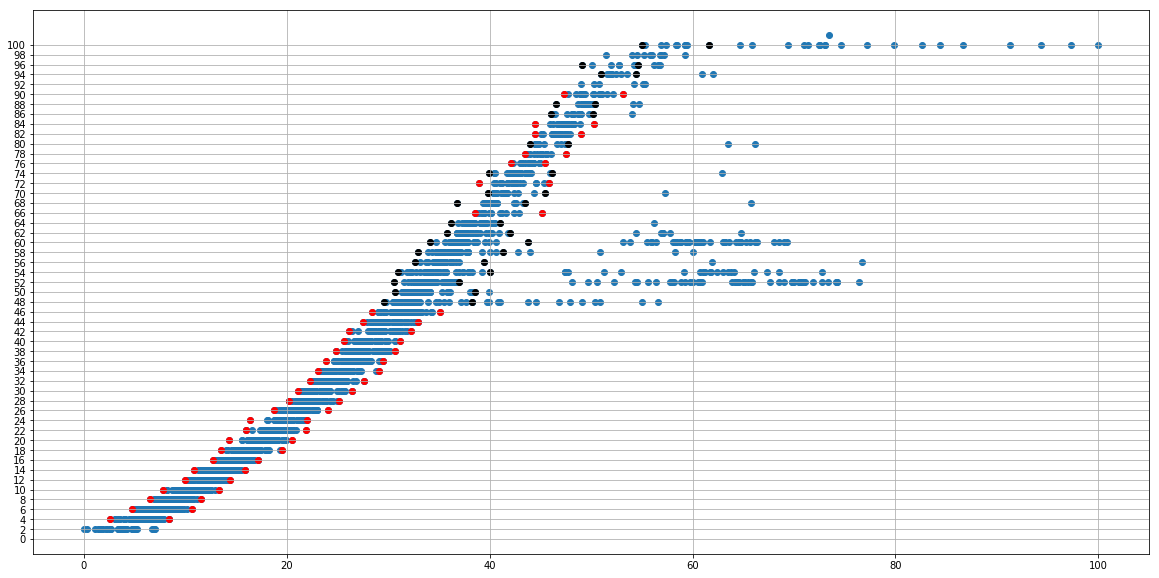

In [5]:
plt.yticks(np.arange(0, 102, 2))
plt.grid(True)
plt.show()